## Performing Regression Analysis on customer data

**How do our customers aggregate and collect loyalty points? Which available<br>
independent variables are influencing the amount of loyalty points accumulated?**

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
# Importing the data

df = pd.read_csv('../turtle_reviews.csv')

# Viewing the dataframe

df

,gender,age,remuneration (k£),spending_score (1-100),loyalty_points,education,language,platform,product,review,summary
0,Male,18,12.30,39,210,graduate,EN,Web,453,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...
1,Male,23,12.30,81,524,graduate,EN,Web,466,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...
2,Female,22,13.12,6,40,graduate,EN,Web,254,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless"
3,Female,25,13.12,77,562,graduate,EN,Web,263,Amazing buy! Bought it as a gift for our new d...,Five Stars
4,Female,33,13.94,40,366,graduate,EN,Web,291,As my review of GF9's previous screens these w...,Money trap
...,...,...,...,...,...,...,...,...,...,...,...
1995,Female,37,84.46,69,4031,PhD,EN,Web,977,The perfect word game for mixed ages (with Mom...,The perfect word game for mixed ages (with Mom
1996,Female,43,92.66,8,539,PhD,EN,Web,979,Great game. Did not think I would like it whe...,Super fun
1997,Male,34,92.66,91,5614,graduate,EN,Web,1012,Great game for all.........\nKeeps the mind ni...,Great Game
1998,Male,34,98.40,16,1048,PhD,EN,Web,1031,fun game!,Four Stars


In [3]:
# Investigate contained observation in language and platform columns

df[['language', 'platform']].nunique()

language    1
platform    1
dtype: int64

In [4]:
# Both columns can be dropped, this also applies to the review
# and the summary column, as we focus on numeric columns and not strings

df = df.drop(columns = ['platform', 'language', 'review', 'summary'])

# Review dataframe

df


,gender,age,remuneration (k£),spending_score (1-100),loyalty_points,education,product
0,Male,18,12.30,39,210,graduate,453
1,Male,23,12.30,81,524,graduate,466
2,Female,22,13.12,6,40,graduate,254
3,Female,25,13.12,77,562,graduate,263
4,Female,33,13.94,40,366,graduate,291
...,...,...,...,...,...,...,...
1995,Female,37,84.46,69,4031,PhD,977
1996,Female,43,92.66,8,539,PhD,979
1997,Male,34,92.66,91,5614,graduate,1012
1998,Male,34,98.40,16,1048,PhD,1031


In [5]:
# Investigate the education column

df['education'].unique()

array(['graduate', 'PhD', 'diploma', 'postgraduate', 'Basic'],
      dtype=object)

In [6]:
# There is a order from lowest to highest educational level:
# Basic -> diploma -> graduate -> postgraduate -> PhD
# Transform the categorical values to numbers to prepare them
# for further analysis:

df['education'] = df['education'].replace(['Basic', 'diploma', 'graduate', 'postgraduate', 'PhD'], 
                                          [1, 2, 3, 4, 5])

# Review the column

df['education'].unique()

array([3, 5, 2, 4, 1])

In [7]:
# Investigate the gender column

df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [8]:
# There seem to be only binary genders listed (Why?)
# Transform the genders into 0 and 1 for further analysis

df['gender'] = df['gender'].replace(['Male', 'Female'], 
                                    [0, 1])

# Review the column

df['gender'].unique()


array([0, 1])

In [9]:
# Checking for NANs

print('Missing values:', df.isna().sum())


Missing values: gender                    0
age                       0
remuneration (k£)         0
spending_score (1-100)    0
loyalty_points            0
education                 0
product                   0
dtype: int64


In [10]:
# Checking for duplicates

duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows

,gender,age,remuneration (k£),spending_score (1-100),loyalty_points,education,product
200,0,18,12.30,39,210,3,466
201,0,23,12.30,81,524,3,254
202,1,22,13.12,6,40,3,263
203,1,25,13.12,77,562,3,291
204,1,33,13.94,40,366,3,977
...,...,...,...,...,...,...,...
1780,1,39,20.50,5,72,3,1031
1977,0,29,18.86,98,1129,3,977
1978,0,58,19.68,35,498,2,979
1979,0,37,19.68,73,994,3,1012


In [11]:
# There are 406 (203) duplicates where all the rows match at least one other row
# I.e., #1780 & #1980. We keep only the first occurence and delete the duplicates 
# This will result in 1797 rows left for analysis and make the outcome more reliable

df = df.drop_duplicates()

# Review the dataframe

df

,gender,age,remuneration (k£),spending_score (1-100),loyalty_points,education,product
0,0,18,12.30,39,210,3,453
1,0,23,12.30,81,524,3,466
2,1,22,13.12,6,40,3,254
3,1,25,13.12,77,562,3,263
4,1,33,13.94,40,366,3,291
...,...,...,...,...,...,...,...
1995,1,37,84.46,69,4031,5,977
1996,1,43,92.66,8,539,5,979
1997,0,34,92.66,91,5614,3,1012
1998,0,34,98.40,16,1048,5,1031


In [12]:
# Rename columns

df = df.rename(columns={'remuneration (k£)': 'remuneration', 'spending_score (1-100)': 'spending_score'})

# Review column names

df.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'product'],
      dtype='object')

In [13]:
# Summary statistics

df.describe()

,gender,age,remuneration,spending_score,loyalty_points,education,product
count,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.560378,39.488036,48.002170,49.989983,1575.977741,3.517529,4325.957707
std,0.496479,13.576661,23.323395,26.110949,1289.865220,1.025482,3148.838110
min,0.000000,17.000000,12.300000,1.000000,25.000000,1.000000,107.000000
25%,0.000000,29.000000,30.340000,32.000000,772.000000,3.000000,1592.000000
50%,1.000000,38.000000,46.740000,50.000000,1272.000000,3.000000,3629.000000
75%,1.000000,49.000000,63.960000,73.000000,1738.000000,4.000000,6678.000000
max,1.000000,72.000000,112.340000,99.000000,6847.000000,5.000000,11086.000000


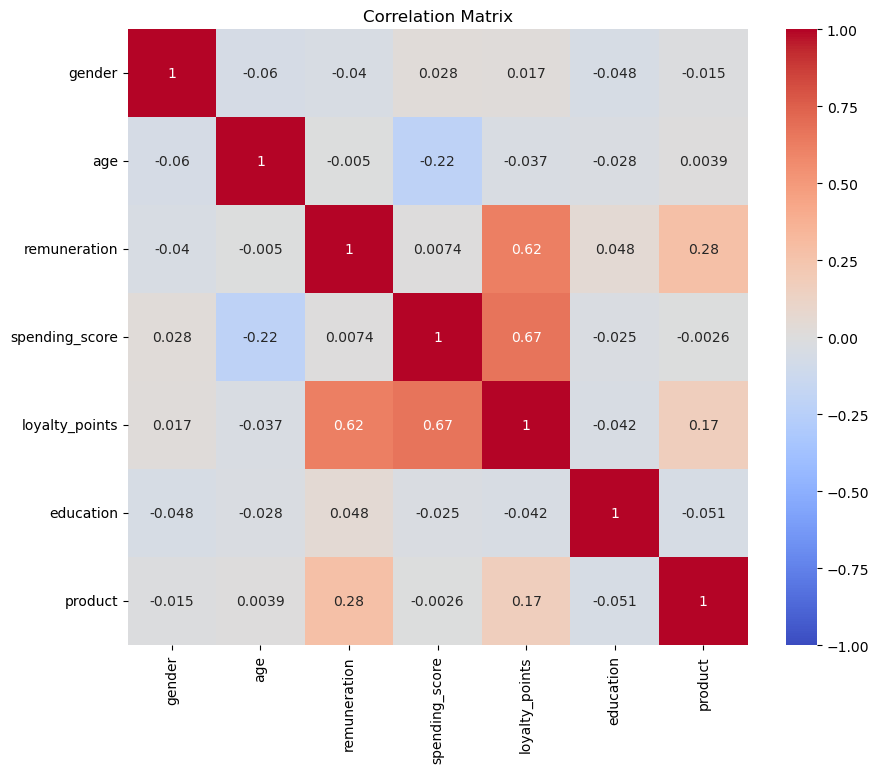

In [14]:
# Explore the correlations

correlation_matrix = df.corr()

# Create a heatmap to visualize correlations

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

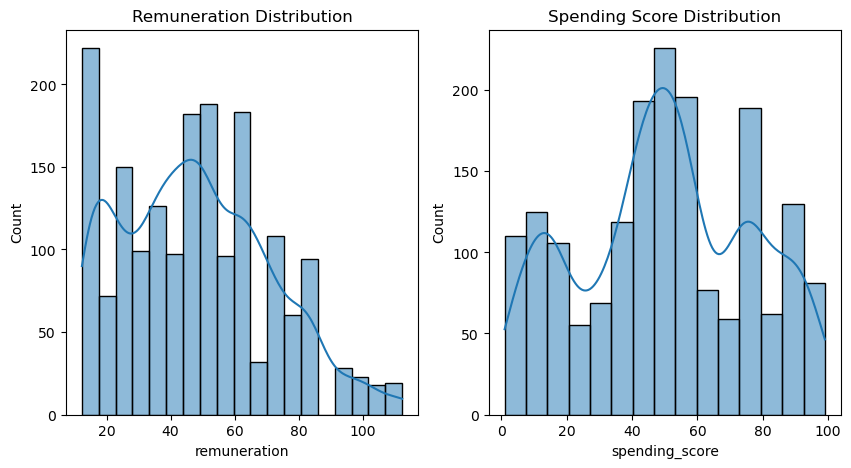

In [15]:
# Correlations look significant for loyalty points vs. remuneration and spending_score
# Investigate the distributions

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram for 'remuneration'

sns.histplot(data=df, x='remuneration', kde=True, ax=axes[0])
axes[0].set_title('Remuneration Distribution')

# Plot the histogram for 'spending_score'

sns.histplot(data=df, x='spending_score', kde=True, ax=axes[1])
axes[1].set_title('Spending Score Distribution')

plt.show()


In [16]:
# Spending_score looks a bit more normally distributed than Remuneration. Both 
# need further investigation for normality. We apply a Shapiro-Wilk-Test:

from scipy.stats import shapiro

remuneration_data = df['remuneration']
spending_score_data = df['spending_score']

# Perform Shapiro-Wilk test for 'remuneration'

statistic_r, p_value_r = shapiro(remuneration_data)
alpha = 0.05
if p_value_r > alpha:
    print("The 'remuneration' data appears to be normally distributed (p-value={:.5f}).".format(p_value_r))
else:
    print("The 'remuneration' data does not appear to be normally distributed (p-value={:.4f}).".format(p_value_r))

# Perform Shapiro-Wilk test for 'spending_score'

statistic_s, p_value_s = shapiro(spending_score_data)
if p_value_s > alpha:
    print("The 'spending_score' data appears to be normally distributed (p-value={:.4f}).".format(p_value_s))
else:
    print("The 'spending_score' data does not appear to be normally distributed (p-value={:.4f}).".format(p_value_s))


The 'remuneration' data does not appear to be normally distributed (p-value=0.0000).
The 'spending_score' data does not appear to be normally distributed (p-value=0.0000).


In [17]:
# As both columns are not normally distributed, we apply a log transformation
# to see if we could achieve normality and add the two new transformed columns to the df

df['remuneration_log'] = np.log(df['remuneration'])
df['spending_score_log'] = np.log(df['spending_score'])

# Review the dataframe

df 


,gender,age,remuneration,spending_score,loyalty_points,education,product,remuneration_log,spending_score_log
0,0,18,12.30,39,210,3,453,2.509599,3.663562
1,0,23,12.30,81,524,3,466,2.509599,4.394449
2,1,22,13.12,6,40,3,254,2.574138,1.791759
3,1,25,13.12,77,562,3,263,2.574138,4.343805
4,1,33,13.94,40,366,3,291,2.634762,3.688879
...,...,...,...,...,...,...,...,...,...
1995,1,37,84.46,69,4031,5,977,4.436278,4.234107
1996,1,43,92.66,8,539,5,979,4.528937,2.079442
1997,0,34,92.66,91,5614,3,1012,4.528937,4.510860
1998,0,34,98.40,16,1048,5,1031,4.589041,2.772589


In [18]:
# Did the log transformation improve normality? 
# Performing Shapiro-Wilk test again

remuneration_data2 = df['remuneration_log']
spending_score_data2 = df['spending_score_log']

# Perform Shapiro-Wilk test for 'remuneration'

statistic_r, p_value_r = shapiro(remuneration_data2)
alpha = 0.05
if p_value_r > alpha:
    print("The 'remuneration' data appears to be normally distributed (p-value={:.4f}).".format(p_value_r))
else:
    print("The 'remuneration' data does not appear to be normally distributed (p-value={:.4f}).".format(p_value_r))

# Perform Shapiro-Wilk test for 'spending_score'

statistic_s, p_value_s = shapiro(spending_score_data2)
if p_value_s > alpha:
    print("The 'spending_score' data appears to be normally distributed (p-value={:.4f}).".format(p_value_s))
else:
    print("The 'spending_score' data does not appear to be normally distributed (p-value={:.4f}).".format(p_value_s))


The 'remuneration' data does not appear to be normally distributed (p-value=0.0000).
The 'spending_score' data does not appear to be normally distributed (p-value=0.0000).


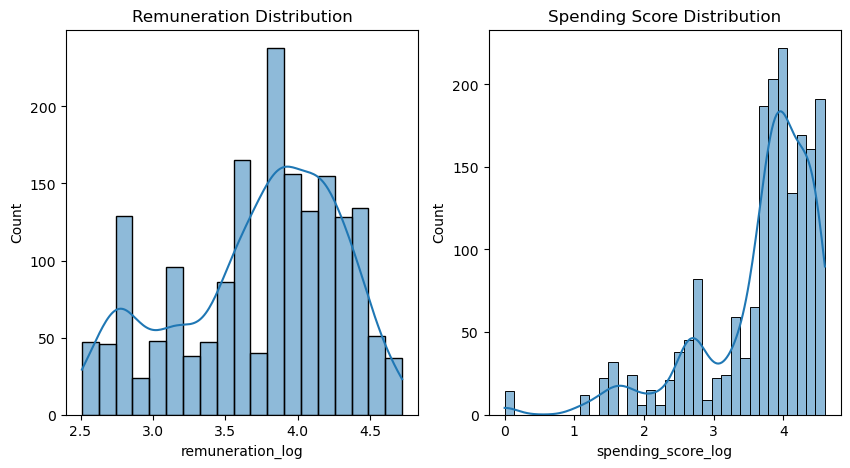

In [19]:
# Log transformation does not seem to provide normality
# Investigate the log transformed distributions

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram for 'remuneration'

sns.histplot(data=df, x='remuneration_log', kde=True, ax=axes[0])
axes[0].set_title('Remuneration Distribution')

# Plot the histogram for 'spending_score'

sns.histplot(data=df, x='spending_score_log', kde=True, ax=axes[1])
axes[1].set_title('Spending Score Distribution')

plt.show()


In [20]:
# As log transformation did not improve normality, Boxcox transformation is applied:

from scipy.stats import boxcox

df['remuneration_boxcox'], lambda_r = boxcox(df['remuneration'])
df['spending_score_boxcox'], lambda_s = boxcox(df['spending_score'])

# Review the dataframe

df


,gender,age,remuneration,spending_score,loyalty_points,education,product,remuneration_log,spending_score_log,remuneration_boxcox,spending_score_boxcox
0,0,18,12.30,39,210,3,453,2.509599,3.663562,4.837552,23.125371
1,0,23,12.30,81,524,3,466,2.509599,4.394449,4.837552,42.982428
2,1,22,13.12,6,40,3,254,2.574138,1.791759,5.054061,4.061954
3,1,25,13.12,77,562,3,263,2.574138,4.343805,5.054061,41.192958
4,1,33,13.94,40,366,3,291,2.634762,3.688879,5.263590,23.633619
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,37,84.46,69,4031,5,977,4.436278,4.234107,15.263365,37.561282
1996,1,43,92.66,8,539,5,979,4.528937,2.079442,16.046597,5.460817
1997,0,34,92.66,91,5614,3,1012,4.528937,4.510860,16.046597,47.387165
1998,0,34,98.40,16,1048,5,1031,4.589041,2.772589,16.573439,10.545200


In [21]:
# Did the Boxcox - transformation improve normality? 
# Performing Shapiro-Wilk test again

remuneration_data3 = df['remuneration_boxcox']
spending_score_data3 = df['spending_score_boxcox']

# Perform Shapiro-Wilk test for 'remuneration_boxcox'

statistic_r, p_value_r = shapiro(remuneration_data3)
alpha = 0.05
if p_value_r > alpha:
    print("The 'remuneration' data appears to be normally distributed (p-value={:.4f}).".format(p_value_r))
else:
    print("The 'remuneration' data does not appear to be normally distributed (p-value={:.4f}).".format(p_value_r))

# Perform Shapiro-Wilk test for 'spending_score_boxcox'

statistic_s, p_value_s = shapiro(spending_score_data3)
if p_value_s > alpha:
    print("The 'spending_score' data appears to be normally distributed (p-value={:.4f}).".format(p_value_s))
else:
    print("The 'spending_score' data does not appear to be normally distributed (p-value={:.4f}).".format(p_value_s))


The 'remuneration' data does not appear to be normally distributed (p-value=0.0000).
The 'spending_score' data does not appear to be normally distributed (p-value=0.0000).


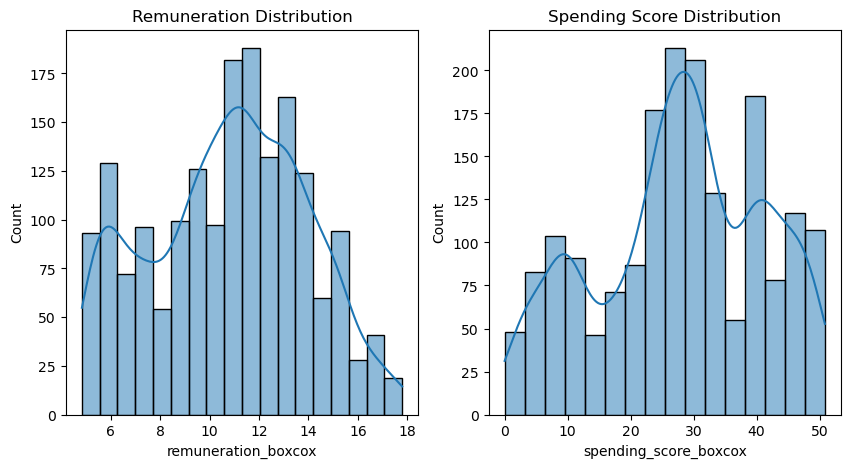

In [22]:
# Log transformation does not seem to provide normality
# Investigate the log transformed distributions with a plot again

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram for 'remuneration'

sns.histplot(data=df, x='remuneration_boxcox', kde=True, ax=axes[0])
axes[0].set_title('Remuneration Distribution')

# Plot the histogram for 'spending_score'

sns.histplot(data=df, x='spending_score_boxcox', kde=True, ax=axes[1])
axes[1].set_title('Spending Score Distribution')

plt.show()


In [23]:
# Plots show slight improvements but Shapiro-Wilk-test results are not convincing, therefore
# it is decided to continue with the initial data and be mindful that normal distribution criteria
# is potentially violated

# Drop the created columns

df = df.drop(columns = ['remuneration_log', 'spending_score_log', 'remuneration_boxcox', 'spending_score_boxcox'])

# Review the dataframe

df

,gender,age,remuneration,spending_score,loyalty_points,education,product
0,0,18,12.30,39,210,3,453
1,0,23,12.30,81,524,3,466
2,1,22,13.12,6,40,3,254
3,1,25,13.12,77,562,3,263
4,1,33,13.94,40,366,3,291
...,...,...,...,...,...,...,...
1995,1,37,84.46,69,4031,5,977
1996,1,43,92.66,8,539,5,979
1997,0,34,92.66,91,5614,3,1012
1998,0,34,98.40,16,1048,5,1031


## Fitting a MLR model with remuneration and spending_score

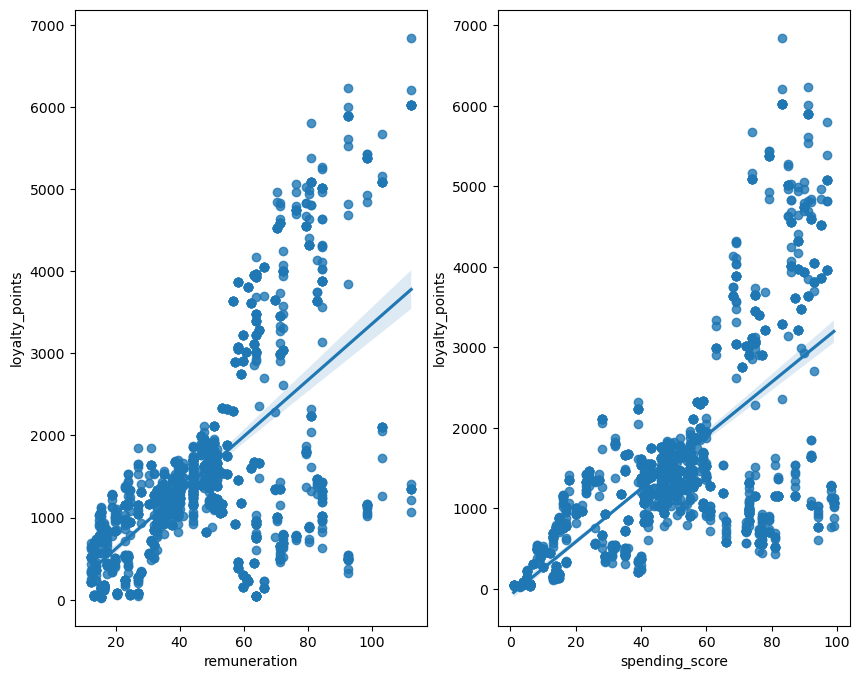

In [24]:
# Assessing linear relationships between independent & dependent variables
# Creating a figure with seaborn

fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plotting the scatterplots with trendlines

sns.regplot(data=df, x='remuneration', y='loyalty_points', ax=axes[0])
sns.regplot(data=df, x='spending_score', y='loyalty_points', ax=axes[1])

# Displaying the plot

plt.show()


In [25]:
# As we were are able to identify a linear relationship, we deploy a LM model using the variables

# Independent variable

y = df['loyalty_points']

# Dependent variables

X = df[['remuneration', 'spending_score']]


In [26]:
# Specifying the model

mlr = LinearRegression()

# Fitting the model

mlr.fit(X,y)

LinearRegression()

In [27]:
# Calling predictions

mlr.predict(X)

array([ 2.14151828e+00,  1.38231733e+03, -1.05442950e+03, ...,
        4.44050782e+03,  2.17087796e+03,  1.71301753e+03])

In [28]:
# Checking the models values
# Display R-squared, showing how much the X's contribute to the variation of Y

print('R-squared', mlr.score(X,y))

# Display the Intercept or constant

print('Intercept:', mlr.intercept_)

# Display the coefficients

list(zip(X, mlr.coef_))


R-squared 0.8258088260963474
Intercept: -1697.2427327619532


[('remuneration', 33.966864148033416), ('spending_score', 32.8613287698179)]

**Regression equation would be roughly: y = 33.97 * remuneration + 32.86 * spending_score - 1697.24**

In [29]:
# Splitting training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=21)

# Training the model using statsmodel
# Fit the model with the added constant

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Define the predictor variable

y_predictor = model.predict(sm.add_constant(X_test))

# Call a model summary

print_model = model.summary()
print(print_model)

# Print the R-squared value

print('\n\033[1mThe R^2 is:\033[0m\n', mlr.score(X_train, y_train)*100)

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     3493.
Date:                Wed, 26 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:45:33   Log-Likelihood:                -11060.
No. Observations:                1437   AIC:                         2.213e+04
Df Residuals:                    1434   BIC:                         2.214e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1720.0143     42.123    -40.

**P-values look great and R^2 shows that 82.9% of the variance in y is explained by our X's.**

In [30]:
# Testing the model

mlr_test = LinearRegression()  
mlr_test.fit(X_train, y_train)

# Call the predictions for X in the train set

y_pred_mlr = mlr_test.predict(X_train)  

# Print the predictions

print("Prediction for test set: {}".format(y_pred_mlr)) 

# Print the R-squared value

print('\n\033[1mThe R^2 is:\033[0m\n', mlr_test.score(X_test, y_test)*100)  

Prediction for test set: [1517.58564706 2407.9251183  2012.69823883 ... 3203.17083298 1684.49454879
 1600.84537637]

The R^2 is:
 80.95650214924447


**The lower R^2 indicates that the model performed slightly worse on the unseen data, but still acceptable.**

In [31]:
# Assumption Check 1:
# Investigating multicollinearity of Xs using Variance Inflation Factor
# Add a constant

x_temp = sm.add_constant(X_train)

# Create a new dataframe
vif = pd.DataFrame()

# Calculate the VIF 
vif['VIF Factor'] = [variance_inflation_factor(x_temp.values, i) for
                    i in range(x_temp.values.shape[1])]

# Create the feature columns
vif['features'] = x_temp.columns

# Print the rounded values
print(vif.round(1))

   VIF Factor        features
0         9.0           const
1         1.0    remuneration
2         1.0  spending_score


**1.0 VIF factors indicate low multicollinearity and no correlation between X's.**

In [32]:
# Assumption Check 2:
# Investigating heteroscedasticity using Breusch-Pagan-test

model = sms.het_breuschpagan(model.resid, model.model.exog) 
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
print(dict(zip(terms, model)))



{'LM stat': 29.62827921622531, 'LM Test p-value': 3.683841313101183e-07, 'F-stat': 15.094431616263357, 'F-test p-value': 3.255527347987869e-07}


**Both p-values are lower than 0.05, leading to a rejection of H0 = Homoscedasticity,<br>
indicating heteroscedasticity, which also violates the assumption that residuals do not vary.**

## Investigating other potential variables

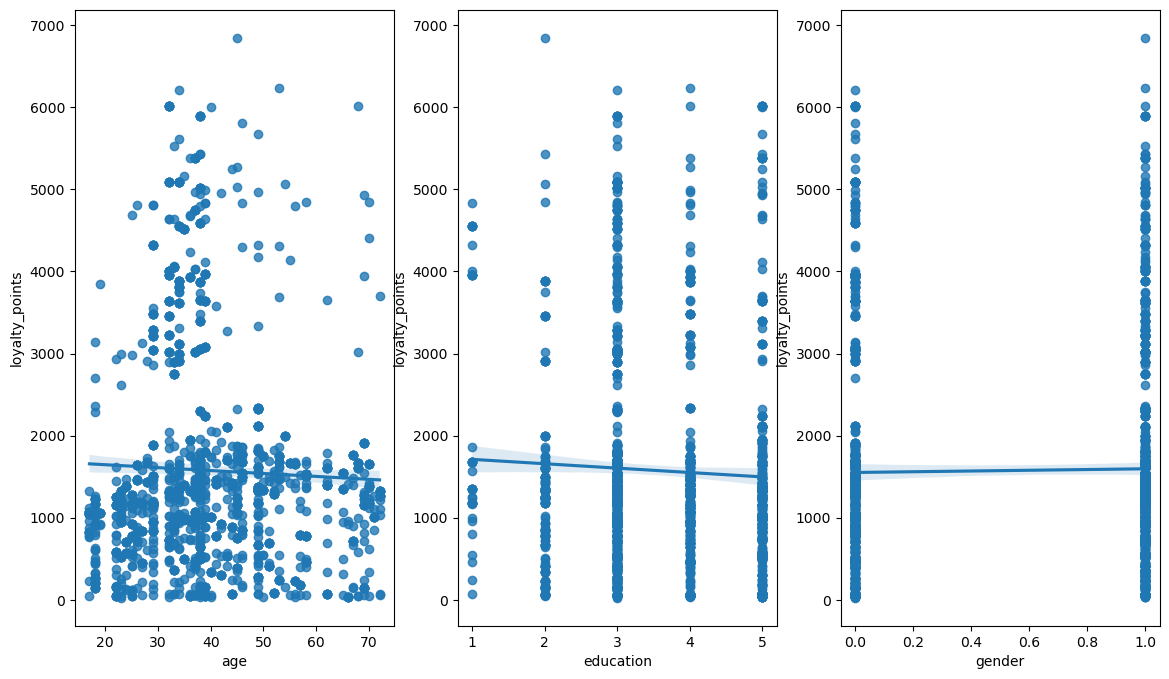

In [33]:
# Assessing linear relationships between independent & dependent variables
# Creating a figure with seaborn

fig, axes = plt.subplots(1, 3, figsize=(14, 8))

# Plotting the scatterplots with trendlines
sns.regplot(data=df, x='age', y='loyalty_points', ax=axes[0])
sns.regplot(data=df, x='education', y='loyalty_points', ax=axes[1])
sns.regplot(data=df, x='gender', y='loyalty_points', ax=axes[2])


# Displaying the plot
plt.show()


**As the correlation matrix already showed, there seems to be no linear relationship between<br>
the other variables and loyalty points. However, for comparison, it was decided to add age to the LM.**

In [34]:
# As we were are able to identify a linear relationship, we deploy a LM model using the variables

# Independent variable

y = df['loyalty_points']

# Dependent variables

X = df[['remuneration', 'spending_score', 'age']]


In [35]:
# Specifying the model

mlr = LinearRegression()

# Fitting the model

mlr.fit(X,y)

LinearRegression()

In [36]:
# Calling predictions

mlr.predict(X)

array([ -247.03970554,  1239.48578841, -1300.48669866, ...,
        4431.95766867,  2070.13918194,  1580.4464386 ])

In [37]:
# Checking the models values
# Display R-squared, showing how much the X's contribute to the variation of Y

print('R-squared', mlr.score(X,y))

# Display the Intercept or constant

print('Intercept:', mlr.intercept_)

# Display the coefficients

list(zip(X, mlr.coef_))


R-squared 0.838425442573208
Intercept: -2191.4486898917903


[('remuneration', 33.9884249371536),
 ('spending_score', 34.09216061161464),
 ('age', 10.930949653841667)]

**Equation: y = 33.99 * remuneration + 34.09 * spending_score + 10.93 * age - 2191.45**


In [38]:
# Splitting training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=21)

# Training the model using statsmodel
# Fit the model with the added constant

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Define the predictor variable

y_predictor = model.predict(sm.add_constant(X_test))

# Call a model summary

print_model = model.summary()
print(print_model)

# Print the R-squared value

print('\n\033[1mThe R^2 is:\033[0m\n', mlr.score(X_train, y_train)*100)

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     2525.
Date:                Wed, 26 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:45:34   Log-Likelihood:                -11011.
No. Observations:                1437   AIC:                         2.203e+04
Df Residuals:                    1433   BIC:                         2.205e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2185.8841     61.632    -35.

**With an adjusted R^2 of 84.1, the model slightly improved.**

In [39]:
# Testing the model

mlr_test = LinearRegression()  
mlr_test.fit(X_train, y_train)

# Call the predictions for X in the train set

y_pred_mlr = mlr_test.predict(X_train)  

# Print the predictions

print("Prediction for test set: {}".format(y_pred_mlr)) 

# Print the R-squared value

print('\n\033[1mThe R^2 is:\033[0m\n', mlr_test.score(X_test, y_test)*100)  

Prediction for test set: [1571.28847775 2312.64136958 1910.73403702 ... 3153.72042871 1919.68855292
 1561.54109144]

The R^2 is:
 82.76625193932018


In [40]:
# Assumption Check 1:
# Investigating multicollinearity of Xs using Variance Inflation Factor
# Add a constant

x_temp = sm.add_constant(X_train)

# Create a new dataframe
vif = pd.DataFrame()

# Calculate the VIF 
vif['VIF Factor'] = [variance_inflation_factor(x_temp.values, i) for
                    i in range(x_temp.values.shape[1])]

# Create the feature columns
vif['features'] = x_temp.columns

# Print the rounded values
print(vif.round(1))

   VIF Factor        features
0        20.5           const
1         1.0    remuneration
2         1.0  spending_score
3         1.0             age


**VIF factors are low, too.**

In [41]:
# Assumption Check 2:
# Investigating heteroscedasticity using Breusch-Pagan-test

model = sms.het_breuschpagan(model.resid, model.model.exog) 
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
print(dict(zip(terms, model)))



{'LM stat': 26.829047939719935, 'LM Test p-value': 6.393745827767234e-06, 'F-stat': 9.0877931363448, 'F-test p-value': 5.840140953846371e-06}


**Same issues regarding heteroscedasticity like in the previous model.**

## Make test predictions

In [42]:
# Extract 3 random X inputs from our test set

random_observations = X_test.sample(n=3, random_state=42)
random_observations

,remuneration,spending_score,age
815,16.40,79,24
664,39.36,51,65
335,59.86,88,29


In [43]:
# Extract the 3 affiliated Y values from the test set

filtered_series = y_test.loc[[815, 664, 335]]
filtered_series


815     701
664    1355
335    3218
Name: loyalty_points, dtype: int64

In [44]:
# Using regression equation from Model 1:
# y = 33.97 * remuneration + 32.86 * spending_score - 1697.24

print('#815 Model 1 Prediction:', 33.97 * 16.4 + 32.86 * 79 - 1697.24)
print('#664 Model 1 Prediction:', 33.97 * 39.36 + 32.86 * 51 - 1697.24)
print('#3218 Model 1 Prediction:', 33.97 * 59.86 + 32.86 * 88 - 1697.24)

#815 Model 1 Prediction: 1455.8079999999998
#664 Model 1 Prediction: 1315.6791999999998
#3218 Model 1 Prediction: 3227.8842000000004


In [45]:
# Using regression equation from Model 2:
# y = 33.99 * remuneration + 34.09 * spending_score + 10.93 * age - 2191.45

print('#815 Model 2 Prediction:', 33.99 * 16.4 + 34.09 * 79 + 10.93 * 24 - 2191.45)
print('#664 Model 2 Prediction:', 33.99 * 39.36 + 34.09 * 51 + 10.93 * 65 - 2191.45)
print('#3218 Model 2 Prediction:', 33.99 * 59.86 + 34.09 * 88 + 10.93 * 29 - 2191.45)


#815 Model 2 Prediction: 1321.4160000000006
#664 Model 2 Prediction: 1595.4364000000005
#3218 Model 2 Prediction: 3160.081400000001


**Although just a random test on 3 observations, our Model 1 showed better results in predicting our y, loyalty points.<br>
As both models violate homoscedasticity assumptions and the variable age used in the second model also <br>
did not show a linear relationship, it is suggested, to follow the approach of simplicity: <br>
Age slightly influenced our R^2, but complicated the model for no significant predictive value.<br>**

**Therefore, it is suggested use Model 1 for predicting loyalty points. However, further analysis should<br>
be conducted and other potential variables should be considered, too.**